## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**5328-2025-S2-Assignment 2**

**student information**

         student id , Name, Unikey
student 1:  550888028, Jiawen Feng, jfen0381

student 2:  540560976, Xingchen Liu,  xliu0101

student 3:  540956939,  Dongqing Hu,  dohu0978

student 4:  540561135, Yitian Zhang, yzha0290

**Instructions: This requires Python 3.13.5, and you should execute the following code in order.**

**Python packages used: numpy, os, PIL, matplotlib, sklearn.metrics, collections, pandas**


## 1. Load Dataset

### 1.0 Data Folder

In [1]:
import os, warnings
os.environ["OMP_NUM_THREADS"] = "2"   #for all devices
warnings.filterwarnings(
    "ignore",
    message="KMeans is known to have a memory leak on Windows with MKL",
    category=UserWarning
)
#set file index
p =2

In [2]:
# # The structure of data folder.
# !ls -l data

### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [3]:
import os
import numpy as np
from PIL import Image

#record the path to reload the origin data

def load_data(root='data/CroppedYaleB'):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels,paths = [], [],[]

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            #new -record the path
            img_path = os.path.join(root, person, fname)
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            # img = img.resize([s//reduce for s in img.size])

            # --- c fixed size (keeps PIL (W,H) order) ---
            root_name = os.path.basename(os.path.normpath(root)).lower()
            if 'orl' in root_name:
                img = img.resize((30, 37), resample=Image.BILINEAR)
            elif 'yaleb' in root_name or 'croppedyaleb' in root_name:
                img = img.resize((42, 48), resample=Image.BILINEAR)

            # --- normalize to [0,1] (nonnegative, NMF-safe) ---
            arr = np.asarray(img, dtype=np.float64) / 255.0
            # convert image to numpy column vector (after preprocessing).
            img = arr.reshape((-1, 1))

            #no-normalize
            img = np.asarray(img).reshape((-1,1))


            # collect data and label.
            images.append(img)
            labels.append(i)
            #collect the path
            paths.append(img_path)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

## 2. Salt and Pepper + Visualization 



In [4]:
import numpy as np
import matplotlib.pyplot as plt

#Salt and Pepper algorithm
def add_salt_pepper_noise(V, p= None, r=None, rng=None):
    V_noisy = V.copy()
    d, n = V.shape
    total_pixels = d * n
    num_corrupt = int(total_pixels * p)


    idx = rng.choice(total_pixels, size=num_corrupt, replace=False)
    num_white = int(num_corrupt * r)
    white_idx = idx[:num_white]
    black_idx = idx[num_white:]


    V_noisy.flat[white_idx] = 1.0
    V_noisy.flat[black_idx] = 0.0
    return V,V_noisy

# Plot result. 
def plot_noise_pic(V_hat,img_size,ind = None, noise_list=None):
    total = 1+len(noise_list)
    rng_init = np.random.RandomState(1)
    plt.figure(figsize=(10,4))
    plt.subplot(1, total, 1)
    plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Original)')
    i = 2
    for (p, r) in noise_list:
        V_hat ,V  = add_salt_pepper_noise(V=V_hat,p=p,r=r,rng= rng_init )
        # Plot result. 
        plt.subplot(1, total, i)
        plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray,vmin= 0,vmax=1)
        plt.title("p={}, r={}".format(p, r))
        i+=1
    plt.tight_layout(pad=2.0)
    plt.show()
    






## 3. NMF Algorithm


In [5]:
#compute relative improvement
def relative_improvement(prev_obj, curr_obj, eps=1e-12):
    return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)

#Visualization
def visualize_reconstruction(V_hat, V_noisy, V_recon, ind=50, img_size=(92,112), title="NMF Reconstruction"):
    plt.suptitle(title, size=16)

    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(V_hat[:, ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title("Image (Original)")

    plt.subplot(132)
    plt.imshow(V_noisy[:, ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title("Image (Noisy)")

    plt.subplot(133)
    plt.imshow(V_recon[:, ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title("Image (Reconstructed)")

    plt.show()
    
eps = 1e-12

### 3.1 L1-NMF

In [6]:
def L1_nmf(V, H, W, steps=3000, tol=1e-4, *,  
           eps=1e-4,          
           omega_cap=1e3,     # limit the weight 
           alpha=0.5,         # learning rate
           floor=1e-12,       # limit the minimum
           min_steps=100,     
           verbose=False):

    V = np.maximum(np.asarray(V, float), floor)
    W = np.maximum(np.asarray(W, float), floor)
    H = np.maximum(np.asarray(H, float), floor)

    obj_prev = np.sum(np.abs(V - W @ H))

    for step in range(1, steps + 1):
        # IRLS weight：Ω = 1/(|E|+eps)
        E = V - (W @ H)
        Q = 1.0 / (np.abs(E) + eps)
        Q = np.minimum(Q, float(omega_cap))

        # update H
        WH   = W @ H
        numH = W.T @ (Q * V)
        denH = W.T @ (Q * WH) + eps
        ratioH = numH / denH
        H = np.maximum(H * (ratioH ** alpha), floor)

        # update W
        WH   = W @ H
        numW = (Q * V) @ H.T
        denW = (Q * WH) @ H.T + eps
        ratioW = numW / denW
        W = np.maximum(W * (ratioW ** alpha), floor)

        # scale W
        s = np.maximum(np.linalg.norm(W, axis=0), floor)
        W /= s
        H *= s[:, None]

        # Convergence determination (relative improvement)
        obj = np.sum(np.abs(V - W @ H))
        rel = abs(obj_prev - obj) / (obj_prev + 1e-12)
        if verbose and step % 100 == 0:
            print(f"[L1-NMF] step={step:4d}  L1={obj:.6e}  rel={rel:.3e}")
        if (step >= min_steps) and (rel < tol):
            if verbose:
                print(f"[L1-NMF] Converged at step={step}, L1={obj:.6e}, rel={rel:.3e}")
            break
        obj_prev = obj

    return W, H, step

### 3.2 L2-NMF


For any data matrix $X$, L2-NMF finds non-negative factors $D \in \mathbb{R}^{w \times k}_{+}$ and $R \in \mathbb{R}^{k \times n}_{+}$ such that
$$
X \approx DR,
$$
by minimizing the Frobenius reconstruction error
$$
\min_{D,R \ge 0}\ \lVert X - DR \rVert_F^2 .
$$

Using multiplicative update rules (MUR), the iteration can be written as
$$
R \leftarrow R \odot \frac{D^\top X}{D^\top D R}, \qquad
D \leftarrow D \odot \frac{X R^\top}{D R R^\top},
$$
where $\odot$ denotes element-wise multiplication.



---------------------------


In [7]:
def L2_NMF(V,H,W,steps,tol=1e-5,verbose=False):
    # H is coeffient matrix
    # W is dictionary matrix
    # V is the matrix with noise
    #V hat  is the original matrix
    # print("basic_NMF")
    obj_prev = np.linalg.norm(V - W @ H, 'fro')**2
    
    for step in range(1, steps+1):    

        H_star = H * (W.T.dot(V)) / (W.T.dot(W).dot(H) + eps)
        W_star = W * (V.dot(H_star.T)) / (W.dot(H_star.dot(H_star.T)) + eps)

        H, W = H_star, W_star

        obj = np.linalg.norm(V - W @ H, 'fro')**2

        rel_impr = relative_improvement(obj_prev, obj, eps=eps)

        if rel_impr < tol:
            if verbose:
                print(f"Converged at step={step}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")
            break

        obj_prev = obj

        if verbose and step in (1000, 5000, 10000, 15000, 20000):
            print(f"step={step}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")

    return W,H, step


### 3.3 L2,1-NMF

In [8]:
def L21_nmf(V, H, W, steps=3000, tol=1e-5, verbose=False,eps = 1e-8,alpha = 1):

    def L21_obj(E):
        return np.sum(np.sqrt(np.sum(E * E, axis=1) + eps))

    obj_prev = L21_obj(V - W @ H)

    for step in range(1, steps + 1):
        # reconstruction loss
        E = V - (W @ H)                               # (d, n)
        row_norm = np.sqrt(np.sum(E * E, axis=1) + eps)  # (d,)
        s = 1.0 / (row_norm**alpha + eps)                    # (d,)

        # S = diag(s)
        SV  = s[:, None] * V
        SWH = s[:, None] * (W @ H)

        # update
        H *= (W.T @ SV) / (W.T @ SWH + eps)

        # update
        SWH = s[:, None] * (W @ H)                    
        W  *= (SV @ H.T) / (SWH @ H.T + eps)

        # Convergence determination (relative improvement)
        obj = L21_obj(V - W @ H)
        rel = relative_improvement(obj_prev, obj, eps=eps)
        # if verbose and (step % 100 == 0):
        #     print(f"[L2,1-NMF] step={step}, obj={obj:.6e}, rel={rel:.3e}")
        if rel < tol:
            if verbose:
                print(f"[L2,1-NMF] Converged at step={step}, obj={obj:.6e}, rel={rel:.3e}")
            break
        obj_prev = obj

    return W, H, step



### 3.4 CIM-NMF
For any data matrix $X$, CIM-NMF finds non-negative factors 
$D \in \mathbb{R}_+^{d \times k}$ and 
$R \in \mathbb{R}_+^{k \times n}$ such that

$$
X \approx DR,
$$

by minimizing the Correntropy-Induced Metric (CIM) reconstruction error:

$$
\min_{D,R \ge 0} \sum_{i=1}^d \sum_{j=1}^n 
\left( 1 - \frac{1}{\sqrt{2\pi}\delta} 
\exp\!\left(-\frac{(X_{ij} - (DR)_{ij})^2}{2\delta^2}\right) \right).
$$

---

### Multiplicative Update Rules (MUR)

Using the weight matrix

$$
W_{ij} = \frac{1}{\sqrt{2\pi}\delta} 
\exp\!\left(-\frac{(X_{ij} - (DR)_{ij})^2}{2\delta^2}\right),
$$

the iteration can be written as

$$
R \leftarrow R \odot \frac{D^\top (W \odot X)}{D^\top (W \odot (DR))}, 
\qquad
D \leftarrow D \odot \frac{(W \odot X) R^\top}{(W \odot (DR)) R^\top},
$$

where $\odot$ denotes element-wise multiplication.

In [9]:
def cim_nmf(V, H,W, max_iter=300, tol=1e-5, rng=None, verbose=False,delta = 1,eps = 1e-12):

    # m, n = V.shape
    # rng = np.random.default_rng(rng)
    # W = np.maximum(rng.random((m, k)), 1e-8)
    # H = np.maximum(rng.random((k, n)), 1e-8)
    obj_prev = np.inf

    eps = eps
    # delta = 1

    for it in range(1, max_iter + 1):
        # restucture
        V_hat = W @ H
        E = V - V_hat

        R = np.exp(-(E**2) / (2 * delta**2)) / (np.sqrt(2*np.pi) * delta)

        obj = np.sum(1 - R)

        # update H
        H *= (W.T @ (R * V)) / (W.T @ (R * V_hat) + eps)
        # update W
        V_hat = W @ H
        W *= ((R * V) @ H.T) / ((R * V_hat) @ H.T + eps)

        rel_impr = relative_improvement(obj_prev, obj, eps)
        if rel_impr < tol:
            # if verbose:
            #     print(f"[CIM-NMF] Converged at iter={it}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")
            break
        obj_prev = obj

        # if verbose and it % 50 == 0:
        #     print(f"[CIM-NMF] iter={it}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")

    return W, H, it


## 4. Evaluation Metrics


### 4.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [10]:
# # Evaluate relative reconstruction errors.
def RRE_calcu(V_hat,V_star,algo,iter_time):
    # print(f"==> Evaluate RRE for {algo} for the {iter_time} time ")
    RRE = np.linalg.norm(V_hat - V_star) / np.linalg.norm(V_hat)
    # print('RRE = {}'.format(RRE))
    return RRE

### 4.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [11]:
#other evaluate 
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y,local_seed,n_init):
    kmeans = KMeans(n_clusters=len(set(Y)),random_state = local_seed,n_init=n_init).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred


def accu_calcu(H,Y_hat,algo,iter_time,local_seed,n_init=10):
    print(f"==> Evaluate Acc and NMI for {algo} for the {iter_time} time ")
    # Assign cluster labels.
    Y_pred = assign_cluster_label(H.T, Y_hat,local_seed,n_init=n_init)
    
    acc = accuracy_score(Y_hat, Y_pred)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    return acc, nmi



## 5. Perform robust experiments

In [12]:
#NMF algo_choice
#basic algotihm
########  L1 
def nmf_L1(V, K, local_seed, steps=3000, tol=1e-5, verbose=False):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L1_nmf(V, H, W, steps=steps, tol=tol, verbose=verbose)
    return W_star, H_star,step_star

######## L2
def nmf_L2(V, K, local_seed, steps=3000, tol=1e-5, verbose=False):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L2_NMF(V, H, W, steps=steps, tol=tol, verbose=verbose)
    return W_star, H_star,step_star

######## L2,1
def nmf_L21(V, K, local_seed, steps=3000, tol=1e-5, verbose=False,eps = 1e-8,alpha = 1):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L21_nmf(V, H, W, steps=steps, tol=tol, verbose=True)
    return W_star, H_star,step_star

########CIM 
def nmf_CIM(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 1,eps = 1e-12):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng, verbose=True, delta = delta,eps = eps)
    return W_star, H_star,step_star

#algorithm tune
def nmf_L21_alpha(V, K, local_seed, steps=3000, tol=1e-5, verbose=False,eps = 1e-12,alpha = 1.4):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L21_nmf(V, H, W, steps=steps, tol=tol, verbose=False,eps = eps,alpha = alpha)
    return W_star, H_star,step_star

def nmf_L21_eps(V, K, local_seed, steps=3000, tol=1e-5, verbose=False,eps = 1e-8,alpha = 1):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L21_nmf(V, H, W, steps=steps, tol=tol, verbose=False,eps = eps,alpha = alpha)
    return W_star, H_star,step_star

def nmf_L21_eps_alpha(V, K, local_seed, steps=3000, tol=1e-5, verbose=False,eps = 1e-8,alpha = 0.8):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L21_nmf(V, H, W, steps=steps, tol=tol, verbose=False,eps = eps,alpha = alpha)
    return W_star, H_star,step_star

def nmf_CIM_delta(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 1.4,eps = 1e-12):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng, verbose=False, delta = delta,eps = eps)
    return W_star, H_star,step_star

def nmf_CIM_eps(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 1,eps = 1e-8):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng,  verbose=False, delta = delta,eps = eps)
    return W_star, H_star,step_star


def nmf_CIM_delta4(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 2,eps = 1e-12):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng,  verbose=False, delta = delta,eps = eps)
    return W_star, H_star,step_star

def nmf_CIM_star_orl(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 0.6,eps = 1e-14):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng,  verbose=False, delta = delta,eps = eps)
    return W_star, H_star,step_star

def nmf_CIM_star_yale(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 0.5,eps = 1e-14):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng,  verbose=False, delta = delta,eps = eps)
    return W_star, H_star,step_star


In [13]:
import pandas as pd
#Perform every combination of algorithm, noise group, randome 90%subset for 3 times
def one_time_nmf(V_hat_all,Y_hat_all,algo,K,p,r,img_size,iter_time,local_seed):
    rng = np.random.RandomState(local_seed)
    
    #  90% subset
    n = V_hat_all.shape[1]
    m = int(np.ceil(0.9 * n))
    idx = rng.choice(n, size=m, replace=False)   
    V_sub = V_hat_all[:, idx]
    y_sub = Y_hat_all[idx]
    
    #add noise
    V_hat,V_noisy = add_salt_pepper_noise(V_sub, p=p, r=r, rng=rng)

    #algo
    W_star, H_star,step_star = algo(V_hat,K,local_seed)
    V_star = W_star @ H_star
    print(f"{algo} final run step with local_seed{local_seed}:",step_star)
    if iter_time == 0 :
        visualize_reconstruction(V_hat, V_noisy, V_star, 50, img_size, title=f"{algo} Reconstruction")

    #metrics
    rre = RRE_calcu(V_hat,V_star,algo,iter_time)
    acc, nmi = accu_calcu(H_star,y_sub,algo,iter_time,local_seed)
    
    return rre, acc, nmi ,step_star

#Pipeline for the whole project     
def robost_pipeline(dataset, algos, noise_list,n_runs = 1,global_seed = 42):
    #load data
    V_hat, Y_hat = load_data(root=f"data/{dataset}")   
    print(f"{dataset} dataset: X.shape = {V_hat.shape}, Y.shape = {Y_hat.shape}")

    if dataset == "ORL":
        # img_size = (92,112) 
        # img_size = [i//2 for i in (92, 112)] # ORL
        img_size = (30,37)
        K = 40
    elif dataset == "CroppedYaleB":
        # img_size = (168,192)
        # img_size = [i//2 for i in (168,192)] 
        img_size = (42,48)
        K= 38
    else: 
        print("can not find the dataset")
    print("K:",K)

    # Noise visualization
    plot_noise_pic(V_hat, img_size, ind=50, noise_list=noise_list)

    results = []
    #wolk through all the algo
    for algo_index, algo in enumerate(algos):
        #add_noise
        for noise_index,noise in enumerate(noise_list):
            p, r = noise
            rre_results = []
            acc_results = []
            nmi_results = []
            step_results = []
            for i in range(n_runs):
                run_index = i
                local_seed =  global_seed*100+(noise_index+1)*10+run_index
                print(f"algo is {algo},noise is {noise}, iter_time is {run_index}, the local_seed is {local_seed}")

                rre, acc, nmi,step_star  = one_time_nmf(V_hat,Y_hat,algo,K,p,r,img_size,run_index,local_seed)
                rre_results.append(rre)
                acc_results.append(acc)
                nmi_results.append(nmi)
                step_results.append(step_star)
            mean_rre, std_rre = np.mean(rre_results), np.std(rre_results, ddof=1)
            mean_acc, std_acc = np.mean(acc_results), np.std(acc_results, ddof=1)
            mean_nmi, std_nmi = np.mean(nmi_results), np.std(nmi_results, ddof=1)
            mean_step, std_step = np.mean(step_results), np.std(step_results, ddof=1)

            print(f"[Algo={algo.__name__}, Noise={noise}, Run={run_index}] "
                  f"RRE={mean_rre:.4f}±{np.std(std_rre):.4f}, "
                  f"ACC={mean_acc:.4f}±{np.std(std_acc):.4f}, "
                  f"NMI={mean_nmi:.4f}±{np.std(std_nmi):.4f}")
            
            results.append({
                "algo": algo.__name__,
                "noise_p": p,
                "noise_r": r,
                "run_index": run_index,
                "RRE": mean_rre,
                "ACC": mean_acc,
                "NMI": mean_nmi,
                "local_seed" :local_seed,
                "final_step":mean_step
            })
    df_result = pd.DataFrame(results)

    # save
    df_result.to_csv(f"data/{dataset}_result.csv", index=False)
    print("save to results.csv")
                    
    

## 6. Result
### 6.1 ORL result

ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
K: 40


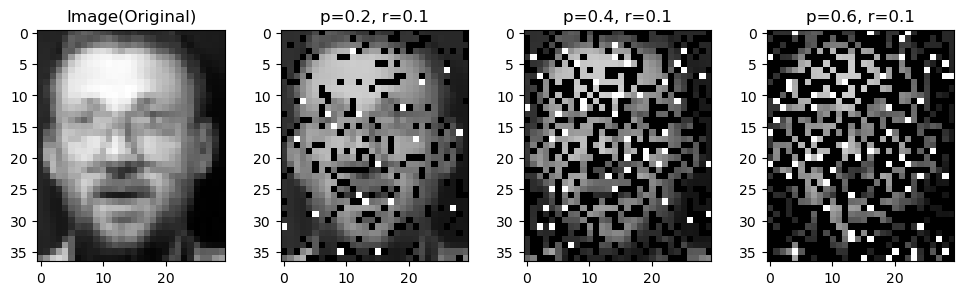

algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4210: 2554


<Figure size 640x480 with 0 Axes>

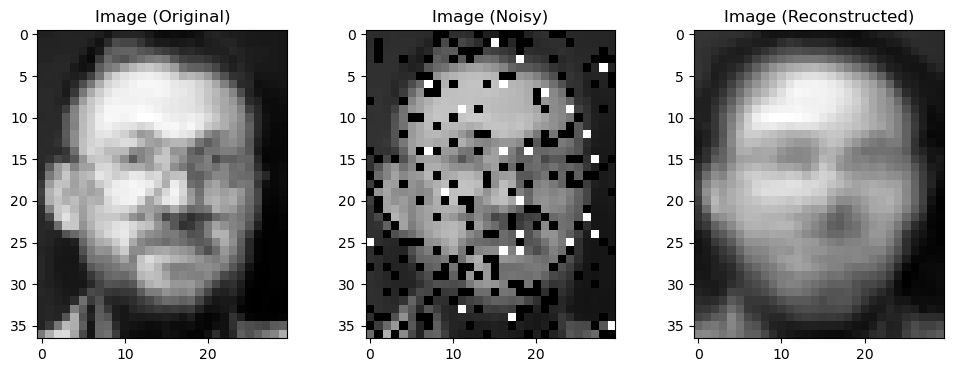

==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 0 time 
Acc(NMI) = 0.7444 (0.8595)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.2, 0.1), iter_time is 1, the local_seed is 4211
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4211: 2538
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 1 time 
Acc(NMI) = 0.7472 (0.8624)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.2, 0.1), iter_time is 2, the local_seed is 4212
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4212: 2597
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 2 time 
Acc(NMI) = 0.7639 (0.8777)
[Algo=nmf_L2, Noise=(0.2, 0.1), Run=2] RRE=0.1097±0.0000, ACC=0.7519±0.0000, NMI=0.8665±0.0000
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.4, 0.1), iter_time is 0, the local_seed is 4220
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4220: 2765


<Figure size 640x480 with 0 Axes>

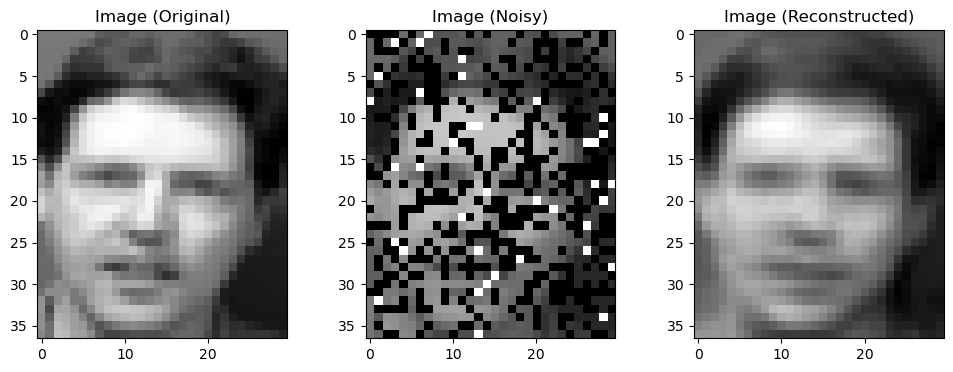

==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 0 time 
Acc(NMI) = 0.7694 (0.8606)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.4, 0.1), iter_time is 1, the local_seed is 4221
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4221: 2322
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 1 time 
Acc(NMI) = 0.7361 (0.8451)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.4, 0.1), iter_time is 2, the local_seed is 4222
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4222: 2599
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 2 time 
Acc(NMI) = 0.7278 (0.8442)
[Algo=nmf_L2, Noise=(0.4, 0.1), Run=2] RRE=0.1097±0.0000, ACC=0.7444±0.0000, NMI=0.8500±0.0000
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.6, 0.1), iter_time is 0, the local_seed is 4230
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4230: 2502


<Figure size 640x480 with 0 Axes>

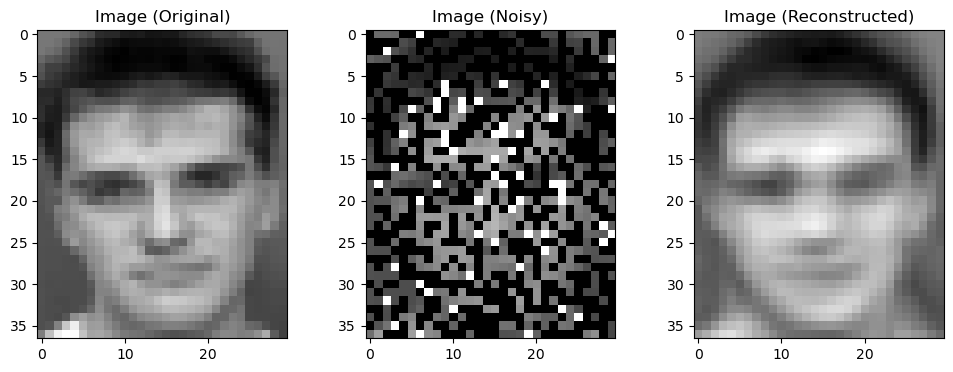

==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 0 time 
Acc(NMI) = 0.7194 (0.8330)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.6, 0.1), iter_time is 1, the local_seed is 4231
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4231: 2329
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 1 time 
Acc(NMI) = 0.7278 (0.8468)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.6, 0.1), iter_time is 2, the local_seed is 4232
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4232: 2608
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 2 time 
Acc(NMI) = 0.7306 (0.8370)
[Algo=nmf_L2, Noise=(0.6, 0.1), Run=2] RRE=0.1096±0.0000, ACC=0.7259±0.0000, NMI=0.8389±0.0000
save to results.csv


In [14]:
dataset_orl = 'ORL'

algos = [nmf_L2,nmf_L1,nmf_L21_eps,nmf_CIM_star_orl]

# algos = [nmf_L2]
noise_list = [(0.2,0.1),(0.4,0.1),(0.6,0.1)]
r = 3

df_result = robost_pipeline(dataset = dataset_orl, algos=algos, noise_list=noise_list,n_runs = r,global_seed = 42)

### 6.2 Yale Result

CroppedYaleB dataset: X.shape = (2016, 2414), Y.shape = (2414,)
K: 38


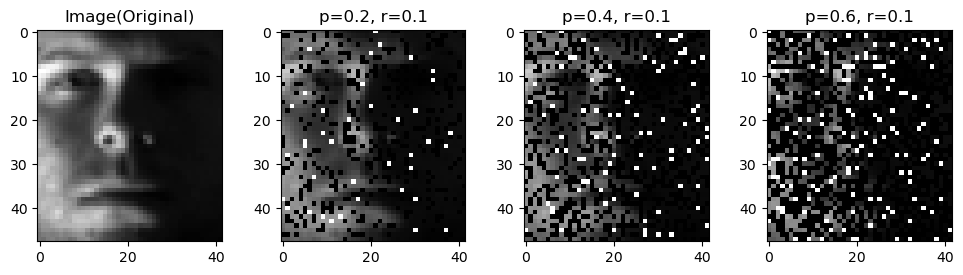

algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4210: 2379


<Figure size 640x480 with 0 Axes>

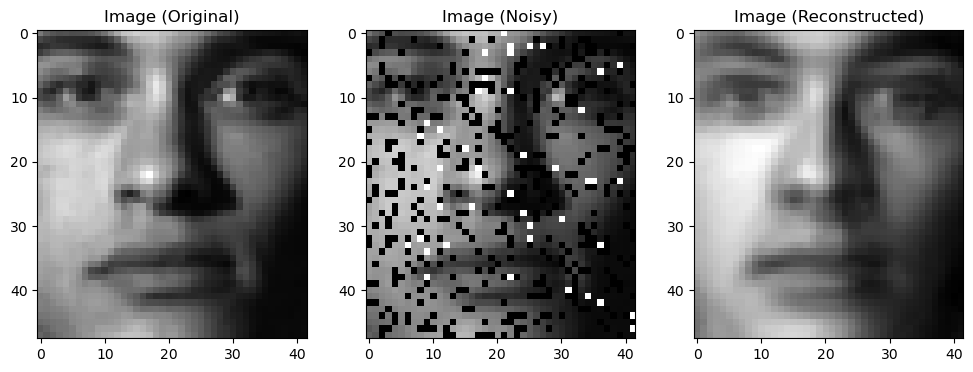

==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 0 time 
Acc(NMI) = 0.2545 (0.3348)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.2, 0.1), iter_time is 1, the local_seed is 4211
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4211: 1596
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 1 time 
Acc(NMI) = 0.2407 (0.3335)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.2, 0.1), iter_time is 2, the local_seed is 4212
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4212: 2104
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 2 time 
Acc(NMI) = 0.2471 (0.3198)
[Algo=nmf_L2, Noise=(0.2, 0.1), Run=2] RRE=0.1708±0.0000, ACC=0.2474±0.0000, NMI=0.3294±0.0000
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.4, 0.1), iter_time is 0, the local_seed is 4220
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4220: 2059


<Figure size 640x480 with 0 Axes>

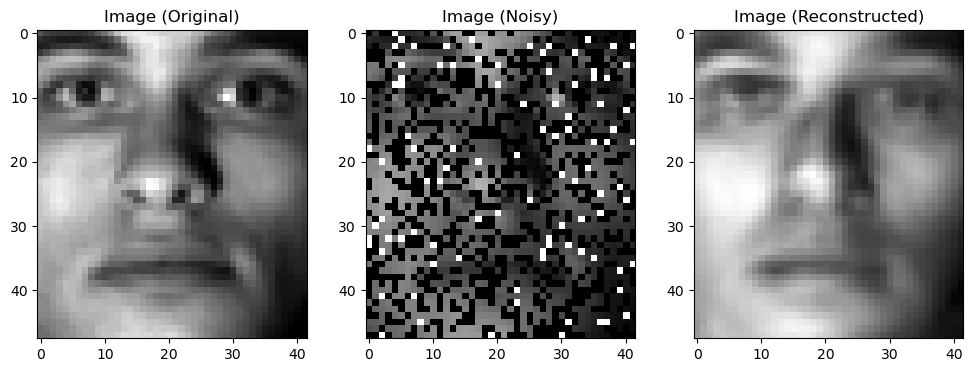

==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 0 time 
Acc(NMI) = 0.2062 (0.2855)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.4, 0.1), iter_time is 1, the local_seed is 4221
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4221: 2481
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 1 time 
Acc(NMI) = 0.2218 (0.2964)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.4, 0.1), iter_time is 2, the local_seed is 4222
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4222: 1987
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 2 time 
Acc(NMI) = 0.2227 (0.3199)
[Algo=nmf_L2, Noise=(0.4, 0.1), Run=2] RRE=0.1706±0.0000, ACC=0.2169±0.0000, NMI=0.3006±0.0000
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.6, 0.1), iter_time is 0, the local_seed is 4230
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4230: 1863


<Figure size 640x480 with 0 Axes>

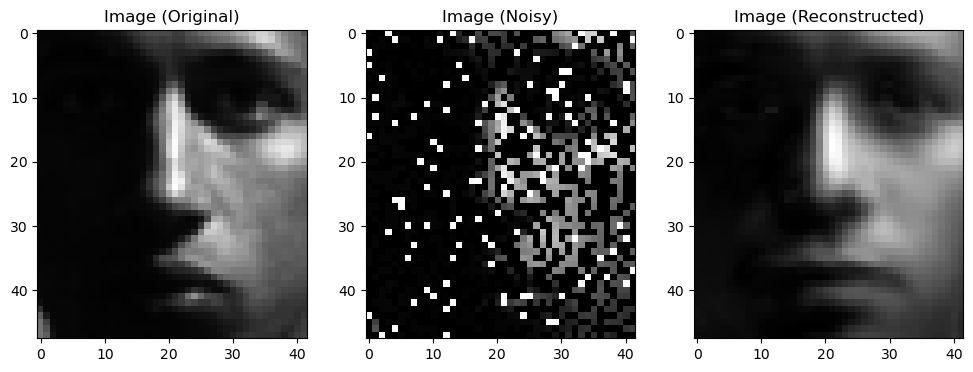

==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 0 time 
Acc(NMI) = 0.2227 (0.3139)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.6, 0.1), iter_time is 1, the local_seed is 4231
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4231: 2049
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 1 time 
Acc(NMI) = 0.2223 (0.3019)
algo is <function nmf_L2 at 0x134fed6c0>,noise is (0.6, 0.1), iter_time is 2, the local_seed is 4232
<function nmf_L2 at 0x134fed6c0> final run step with local_seed4232: 1829
==> Evaluate Acc and NMI for <function nmf_L2 at 0x134fed6c0> for the 2 time 
Acc(NMI) = 0.2204 (0.2984)
[Algo=nmf_L2, Noise=(0.6, 0.1), Run=2] RRE=0.1699±0.0000, ACC=0.2218±0.0000, NMI=0.3047±0.0000
save to results.csv


In [15]:
algos = [nmf_L2,nmf_L1,nmf_L21_eps_alpha,nmf_CIM_star_yale]
# algos = [nmf_L2]

noise_list = [(0.2,0.1),(0.4,0.1),(0.6,0.1)]
r = 3

# df_result = robost_pipeline(dataset = dataset_orl, algos=algos, noise_list=noise_list,n_runs = r,global_seed = 42)
dataset_yale = 'CroppedYaleB'
df_result_yale = robost_pipeline(dataset = dataset_yale, algos=algos, noise_list=noise_list,n_runs = r,global_seed = 42)